In [1]:
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance,ImageStat
import skvideo
import skvideo.io
import numpy as np
import os
from tqdm import tqdm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
def get_contrast(frame):
    return frame.mean(axis=-1).std()

def get_brightness(frame):
    return frame.mean()

def get_mean_rbg(frame):
    return frame.mean(axis=0).mean(axis=0)

In [13]:
from scipy.cluster.hierarchy import linkage,dendrogram

def get_triu(inMat):
    #inMat = rdm_bg

    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]

    #assert (squareform(triu_vec)==inMat).sum()/(n**2)>.9, 'unfaithful triu'
    return triu_vec

In [11]:
## GOOD VALUES
contrast_target = 50
brightness_target = 125
ctargets = np.array([125,90,85])

## Original Data

In [131]:
#indir = ofdir
#indir = '../stimuli/stimuli_working_dir/stimuli_normed_cb/'
#indir = '../stimuli/stimuli_working_dir/stimuli_normed_hue_cb/'
#indir = '../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/'
indir = '../stimuli/stimuli_working_dir/stimuli_cropped/'
files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
files.sort()
n = len(files)
print(n)
files[0:5]

70


['../stimuli/stimuli_working_dir/stimuli_cropped/id1d1.mp4',
 '../stimuli/stimuli_working_dir/stimuli_cropped/id1d2.mp4',
 '../stimuli/stimuli_working_dir/stimuli_cropped/id1f1.mp4',
 '../stimuli/stimuli_working_dir/stimuli_cropped/id1f2.mp4',
 '../stimuli/stimuli_working_dir/stimuli_cropped/id1h1.mp4']

In [132]:
all_contrast = []
all_brightness = []
all_rbg = []

first_frame_orig = []
for f in tqdm(range(len(files))):
    video_data = load_video(files[f])
    first_frame_orig.append(video_data[0,:,:,:])
    n = video_data.shape[0]

    all_contrast.append( get_contrast(video_data[0,:,:,:]) )
    all_brightness.append( get_brightness(video_data[0,:,:,:]) )
    all_rbg.append( get_mean_rbg(video_data[0,:,:,:]) )
    
all_contrast = np.array(all_contrast)
all_brightness = np.array(all_brightness)
all_rbg = np.array(all_rbg)

100%|███████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


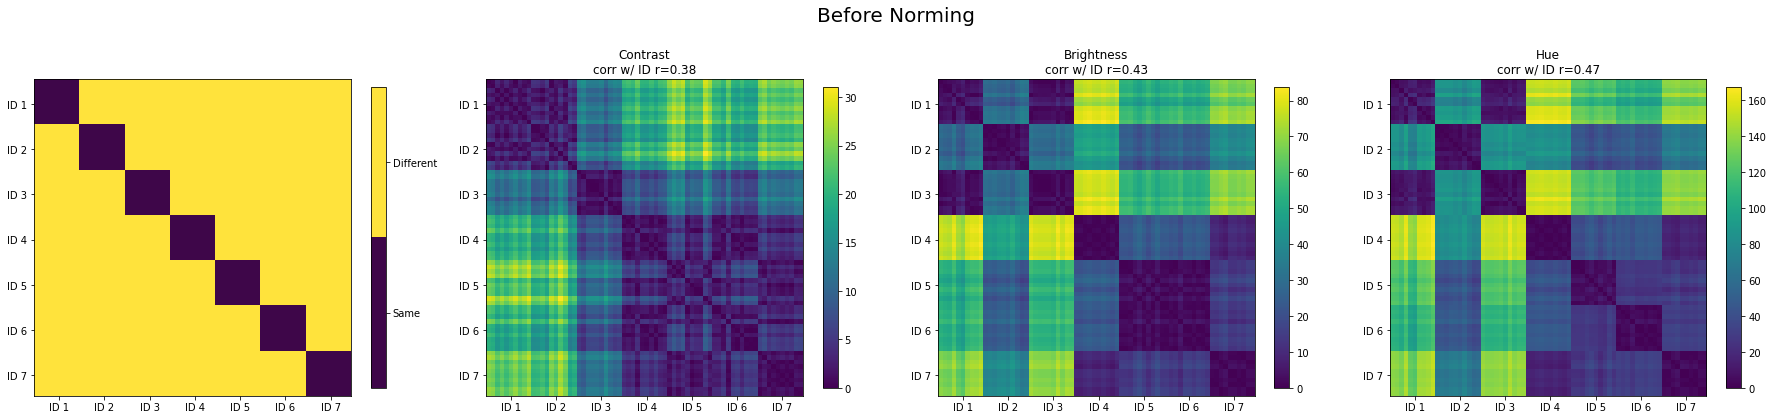

In [133]:
## ID SIMILARITY 
from scipy.spatial.distance import pdist,squareform
from scipy.stats import kendalltau,pearsonr

id_vec = np.hstack([np.repeat(i,10) for i in range(7)])
id_sim = squareform(pdist(id_vec[:,np.newaxis]))
id_sim[id_sim>0] = 1

sim_contrast = squareform(pdist((all_contrast-contrast_target)[:,np.newaxis]))
sim_brightness = squareform(pdist((all_brightness-brightness_target)[:,np.newaxis]))
sim_hue = squareform(pdist(all_rbg-ctargets))

rsa_contrast = kendalltau(get_triu(id_sim),get_triu(sim_contrast))[0]
rsa_brightness = kendalltau(get_triu(id_sim),get_triu(sim_brightness))[0]
rsa_hue = kendalltau(get_triu(id_sim),get_triu(sim_hue))[0]

### Fancy color thing
labels = np.array(['Same','Different'])
len_lab = len(labels)
col_dict={0:[62/255,6/255,73/255],1:[255/255,227/255,60/255]}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
### /end

plt.figure(figsize=(25,10))
plt.subplot(1,4,1);plt.imshow(id_sim,cmap=cm, norm=norm);plt.colorbar(format=fmt, ticks=[0,1],shrink=.45);

xs = np.arange(5,66,10)
plt.xticks(xs,labels=[f'ID {i+1}' for i in range(7)])
plt.yticks(xs,labels=[f'ID {i+1}' for i in range(7)])

plt.subplot(1,4,2);plt.imshow(sim_contrast);plt.colorbar(shrink=.45);plt.title(f'Contrast\ncorr w/ ID r={rsa_contrast:.2f}')

xs = np.arange(5,66,10)
plt.xticks(xs,labels=[f'ID {i+1}' for i in range(7)])
plt.yticks(xs,labels=[f'ID {i+1}' for i in range(7)])

plt.subplot(1,4,3);plt.imshow(sim_brightness);plt.colorbar(shrink=.45);plt.title(f'Brightness\ncorr w/ ID r={rsa_brightness:.2f}')

xs = np.arange(5,66,10)
plt.xticks(xs,labels=[f'ID {i+1}' for i in range(7)])
plt.yticks(xs,labels=[f'ID {i+1}' for i in range(7)])

plt.subplot(1,4,4);plt.imshow(sim_hue);plt.colorbar(shrink=.45);plt.title(f'Hue\ncorr w/ ID r={rsa_hue:.2f}')

xs = np.arange(5,66,10)
plt.xticks(xs,labels=[f'ID {i+1}' for i in range(7)])
plt.yticks(xs,labels=[f'ID {i+1}' for i in range(7)])

plt.suptitle('Before Norming',x=0.5,y=.8,fontsize=20)
plt.tight_layout()

In [134]:
range_contrast = (sim_contrast.min(),sim_contrast.max())
range_brightness = (sim_brightness.min(),sim_brightness.max())
range_hue = (sim_hue.min(),sim_hue.max())

print(range_contrast)
print(range_brightness)
print(range_hue)

(0.0, 31.053357687433724)
(0.0, 83.75654983520508)
(0.0, 167.35722275247628)


## Normed Data

In [135]:
indir = '../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/'
files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
files.sort()
n = len(files)
print(n)
files[0:5]

all_contrast = []
all_brightness = []
all_rbg = []

first_frame_normed = []
for f in tqdm(range(len(files))):
    video_data = load_video(files[f])
    first_frame_normed.append(video_data[0,:,:,:])
    n = video_data.shape[0]

    all_contrast.append( get_contrast(video_data[0,:,:,:]) )
    all_brightness.append( get_brightness(video_data[0,:,:,:]) )
    all_rbg.append( get_mean_rbg(video_data[0,:,:,:]) )
    
all_contrast = np.array(all_contrast)
all_brightness = np.array(all_brightness)
all_rbg = np.array(all_rbg)

70


100%|███████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


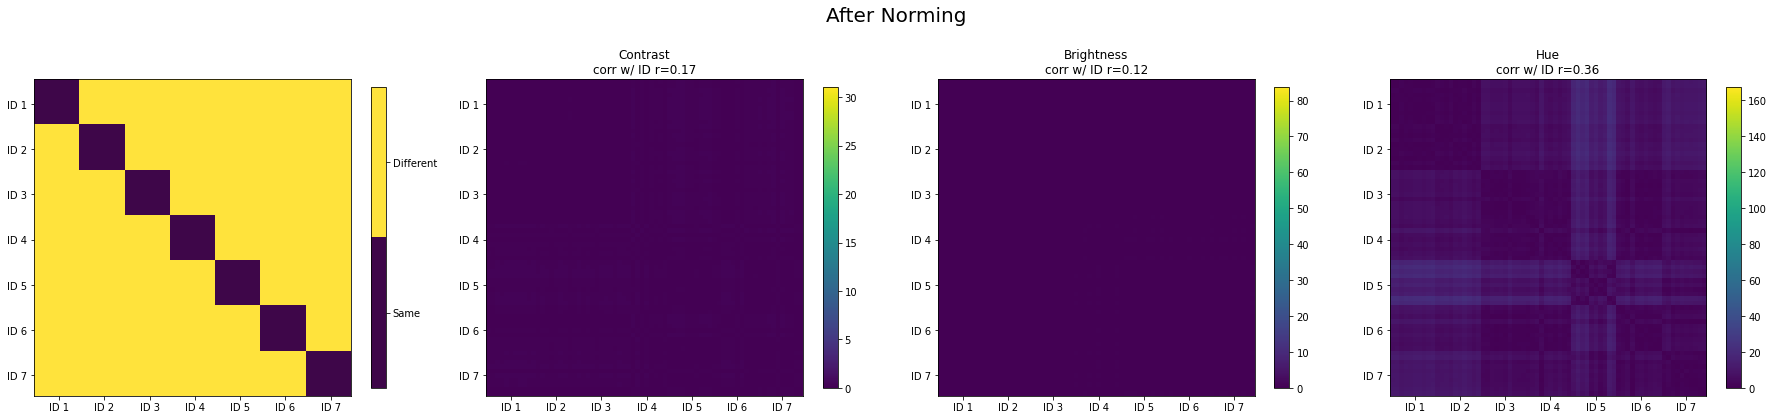

In [136]:
## ID SIMILARITY 
from scipy.spatial.distance import pdist,squareform
from scipy.stats import kendalltau,pearsonr

id_vec = np.hstack([np.repeat(i,10) for i in range(7)])
id_sim = squareform(pdist(id_vec[:,np.newaxis]))
id_sim[id_sim>0] = 1

sim_contrast = squareform(pdist((all_contrast-contrast_target)[:,np.newaxis]))
sim_brightness = squareform(pdist((all_brightness-brightness_target)[:,np.newaxis]))
sim_hue = squareform(pdist(all_rbg-ctargets))

rsa_contrast = kendalltau(get_triu(id_sim),get_triu(sim_contrast))[0]
rsa_brightness = kendalltau(get_triu(id_sim),get_triu(sim_brightness))[0]
rsa_hue = kendalltau(get_triu(id_sim),get_triu(sim_hue))[0]

### Fancy color thing
labels = np.array(['Same','Different'])
len_lab = len(labels)
col_dict={0:[62/255,6/255,73/255],1:[255/255,227/255,60/255]}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
### /end

plt.figure(figsize=(25,10))
plt.subplot(1,4,1);plt.imshow(id_sim,cmap=cm, norm=norm);plt.colorbar(format=fmt, ticks=[0,1],shrink=.45);

xs = np.arange(5,66,10)
plt.xticks(xs,labels=[f'ID {i+1}' for i in range(7)])
plt.yticks(xs,labels=[f'ID {i+1}' for i in range(7)])


plt.subplot(1,4,2);plt.imshow(sim_contrast,vmin=range_contrast[0],vmax=range_contrast[1]);plt.colorbar(shrink=.45);plt.title(f'Contrast\ncorr w/ ID r={rsa_contrast:.2f}')

xs = np.arange(5,66,10)
plt.xticks(xs,labels=[f'ID {i+1}' for i in range(7)])
plt.yticks(xs,labels=[f'ID {i+1}' for i in range(7)])

plt.subplot(1,4,3);plt.imshow(sim_brightness,vmin=range_brightness[0],vmax=range_brightness[1]);plt.colorbar(shrink=.45);plt.title(f'Brightness\ncorr w/ ID r={rsa_brightness:.2f}')

xs = np.arange(5,66,10)
plt.xticks(xs,labels=[f'ID {i+1}' for i in range(7)])
plt.yticks(xs,labels=[f'ID {i+1}' for i in range(7)])

plt.subplot(1,4,4);plt.imshow(sim_hue,vmin=range_hue[0],vmax=range_hue[1]);plt.colorbar(shrink=.45);plt.title(f'Hue\ncorr w/ ID r={rsa_hue:.2f}')

xs = np.arange(5,66,10)
plt.xticks(xs,labels=[f'ID {i+1}' for i in range(7)])
plt.yticks(xs,labels=[f'ID {i+1}' for i in range(7)])


plt.suptitle('After Norming',x=0.5,y=.8,fontsize=20)
plt.tight_layout()

Text(0.5, 0.98, 'Stimuli examples')

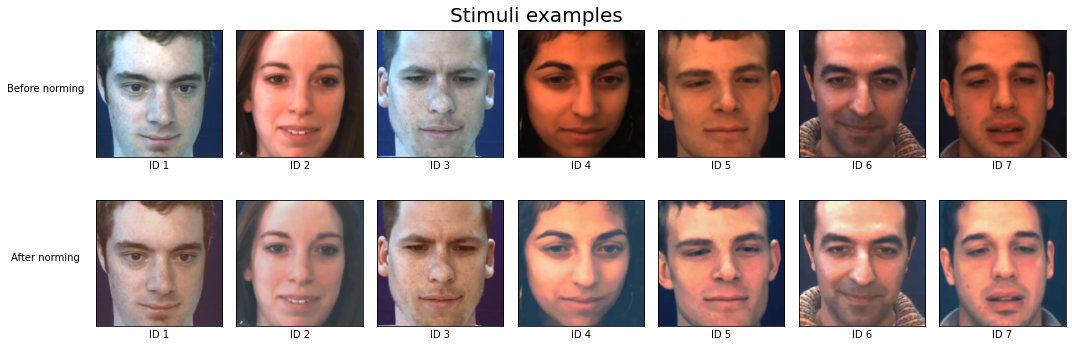

In [ ]:
plt.figure(figsize=(15,5))
for i,x in enumerate(xs):
    plt.subplot(2,7,i+1)
    plt.imshow(np.array(first_frame_orig)[x,:,:,:])
    plt.yticks([]);plt.xticks([]);
    plt.xlabel(f'ID {i+1}')
    if i==0:
        plt.ylabel('Before norming',rotation=0,labelpad=50)
    #plt.axis('off')
    
for i,x in enumerate(xs):
    plt.subplot(2,7,i+1+7)
    plt.imshow(np.array(first_frame_normed)[x,:,:,:])
    #plt.axis('off')
    plt.yticks([]);plt.xticks([]);
    plt.xlabel(f'ID {i+1}')
    if i==0:
        plt.ylabel('After norming',rotation=0,labelpad=50)
        
plt.tight_layout()
plt.suptitle('Stimuli examples',fontsize=20)